# K-MEANS CLUSTERING

Its an un supervised machine learning algorithm. here data pionts are grouped into k no of clusters based on their similiarity or dissimiliarity, where k is the no of clusters we need. 

Working of K-Mean Clustering:

Conside in our case k=2

1. algorithm find 2 random points, the centroids(no need to be a data point)
2. It maps nearest data points to these centroids by calculating its eucledean distance from the centroids
3. It will move these centroid to new location, to the center (avg) of data points mapped
4. It will again map the data pionts to nearest centroid by calculating its eucledean distance 
5. if there is no new mapping of data points happening, we can stop the process and we got  our clusters 
6. if there is a re-mapping of data points happened , we need to go back step 3 & 4 until there is no re-mapping of data points are happening



### Problem Statement:

The dataset we have contains only the height (inches) and weights (pounds) of 25,000 different humans of 18 years of age. We need to segment the humans based on their similiaritie or disimiliaties in their Height & Weight.

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# read dataset into python environment
data=pd.read_csv("HeightWeight.csv")

In [3]:
# first 3 rows of dataset
data.head(3)

,Index,Height(Inches),Weight(Pounds)
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269


In [10]:
# shape of the dataset
data.shape

(25000, 3)

It has 25000 rows & 3 columns

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Height(Inches),25000.0,67.993114,1.901679,60.27836,66.704397,67.99570,69.272958,75.1528
Weight(Pounds),25000.0,127.079421,11.660898,78.01476,119.308675,127.15775,134.892850,170.9240


From the above statistical summary, we can see that mean & Median(50% quartile) are almost same, it suggests that the data is symmetrically distributed and does not have any significant skewness in either direction.
by looking the max value & means we can say that max values in these 2 columns are outliers 

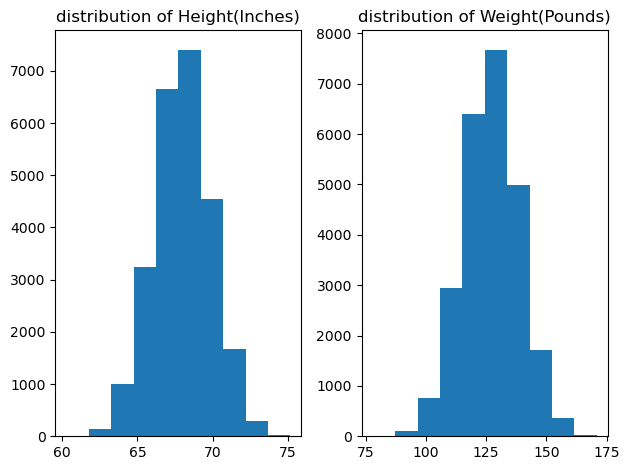

In [78]:
# view the distribution of the columns
plt.subplot(1,2,1)
plt.hist(data["Height(Inches)"])
plt.title("distribution of Height(Inches)")

plt.subplot(1,2,2)
plt.hist(data["Weight(Pounds)"])
plt.title("distribution of Weight(Pounds)")

plt.tight_layout()
plt.show()

From the graph , we can see that Height & Weight are symmetrical. but still there is a skewness

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Height(Inches)  25000 non-null  float64
 1   Weight(Pounds)  25000 non-null  float64
dtypes: float64(2)
memory usage: 390.8 KB


We have only 2 columns and Both are numerical

In [11]:
# removing the index column
data.drop(["Index"],axis=1,inplace=True)

In [13]:
# check for the null values
data.isna().sum()

Height(Inches)    0
Weight(Pounds)    0
dtype: int64

There is no null values in the dataset

# Handling of Outliers

<AxesSubplot:>

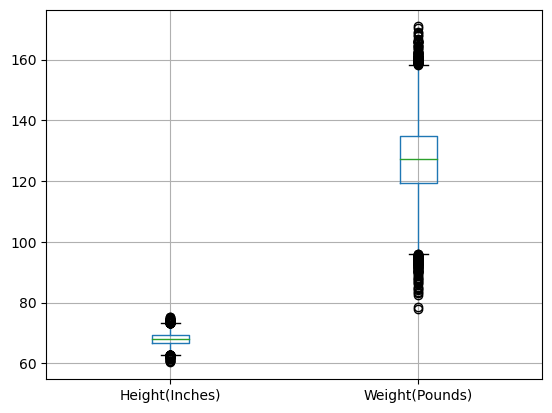

In [24]:
# check for outliers
data[["Height(Inches)","Weight(Pounds)"]].boxplot()

it means that there are data points that are significantly different from the majority of the data and lie outside the range of typical values. 

In [130]:
#creating a function to extract outlier values using IQR

def extract_outliers(df,columns):
    #create an empty dataframe
    outliers=pd.DataFrame()

    for i in columns:
        Q1=np.percentile(data[i],25,interpolation="midpoint")
        Q3=np.percentile(data[i],75,interpolation="midpoint")
        
        #calculate IQR
        IQR=Q3-Q1
        
        # set the upper & lower limit
        upper_lim= Q3 + (1.5* IQR)
        lower_lim= Q1 - (1.5 * IQR)
        
        #extracting values that falls above and below the limit
        outliers_df=data[(data[i]>upper_lim)| (data[i]<lower_lim)]
        
        # concatenating the dtaframes
        outliers=pd.concat([outliers,outliers_df])
    
    # outlier dataframe might have duplicate rows, so we are removing the duplicate rows
    outliers = outliers.drop_duplicates()
    return outliers

In [131]:
# finding the outliers in the columns
outliers_df=extract_outliers(data,["Height(Inches)","Weight(Pounds)"])

In [140]:
# shape of the outlier dataframe
outliers_df.shape

(343, 2)

so we have 343 rows in outlier dataframe

In [153]:
#lets calculate BMI,703 is the conversion factor

data["BMI"]= round(((data["Weight(Pounds)"])/(data["Height(Inches)"]**2)) * 703,2)

In [155]:
# min value of BMI
data["BMI"].min()

13.07

In [157]:
#max value of BMI
data["BMI"].max()

26.02

The healthy range of BMI for 18 year old is between 18.2 to 26.3. so we should consider those outliers having too low values

In [164]:
data[data["BMI"]<14].index

Int64Index([249, 293, 5366, 11485, 15005, 21101, 24610], dtype='int64')

In [165]:
# drop those rows from the dataset
data.drop([249, 293, 5366, 11485, 15005, 21101, 24610],inplace=True)

# Clustering

we can devide process into two,

step1: Finding Optimal value for K using Elbow (WCSS) method -To avoid Random initialisation trap</br>
step2: use K-Means algorithm with optimal k value to make the k clusters  

### Step1:

Random Initialisation is when the user chooses the value of K randomly and the algorithm create clusters based on this k value. This may lead to generating wrong clusters. so we will find an optimal value of K.

In the elbow method, we are calculating WCSS(within cluster sum of square) value for a set of k values. then we draw a line graph for k & WCSS and observe optimal value from the graph.

For k=3, we will have 3 clusters</br>

 WSCC= [sum(squared distance between centriod & data points) in <b>Cluster1</b>] + 
       [sum(squared distance between centriod & data points) in <b>Cluster2</b>]+
        [sum(squared distance between centriod & data points) in <b>Cluster3</b>]

In this case we are only considering Height & Weight columns for clustering

In [204]:
X=data.iloc[:,[0,1]].values

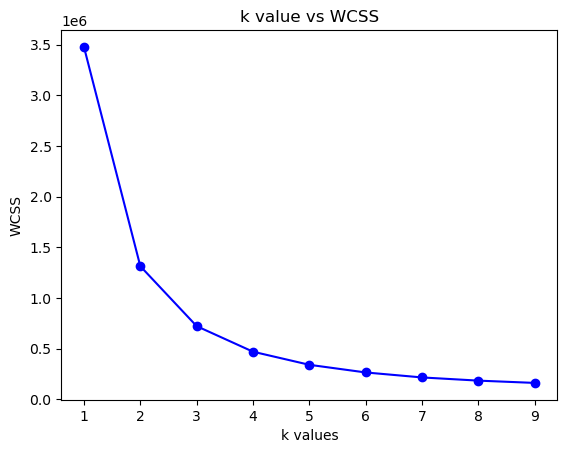

In [219]:
# import K-Means algoritm
from sklearn.cluster import KMeans

WCSS=[]

for k in range(1,10):
    # create an instance
    kmean=KMeans(n_clusters=k,init='k-means++',random_state=42)
    # fit the data into the model
    kmean.fit(X)
    # calculating WCSS and appending to the list
    WCSS.append(kmean.inertia_)

plt.plot(range(1,10),WCSS,marker='o', color='b')
plt.title("k value vs WCSS")
plt.xlabel("k values")
plt.ylabel("WCSS")
plt.show()

we can observe a drastic change in WCSS for k=3, so we can choose that as optimal value.

### Step 2:

creating 3 clusters in our dataset

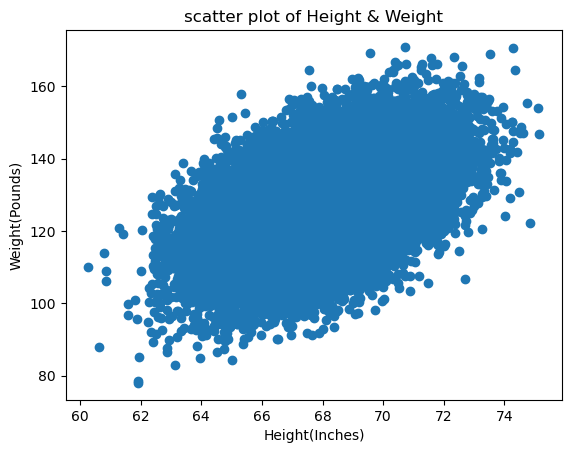

In [242]:
# lets visualise the datapoints before clustering

plt.scatter(data["Height(Inches)"],data["Weight(Pounds)"])
plt.xlabel("Height(Inches)")
plt.ylabel("Weight(Pounds)")
plt.title("scatter plot of Height & Weight")
plt.show()

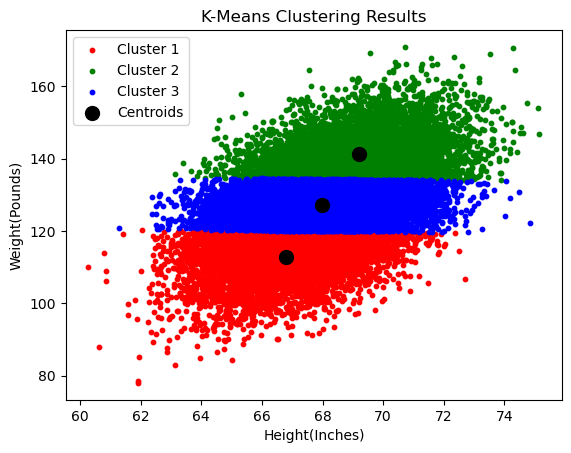

In [232]:
# Perform K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans.fit(X)

# Extract the labels and centers from the K-Means clustering results
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# plot the data points with different colors for each cluster
colors = ['r', 'g', 'b']
for i in range(3):
    #X is a 2D numpy array having height & weight details
    #X[labels == 1, 0] means datapoints height values in the cluster 1
    #X[labels == 1, 1] means datapoints Weight values in the cluster 1
    # we are plotting Height vs Weight for the all 3 clusters
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=10, c=colors[i], label=f'Cluster {i+1}')

# plot the cluster centers as black dots
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids')

# add axis labels and a title
plt.xlabel("Height(Inches)")
plt.ylabel("Weight(Pounds)")
plt.title("K-Means Clustering Results")

# add a legend
plt.legend()

# show the plot
plt.show()

Result:</br>
Teens under Cluster1 needs to meet any healthcare provider to determine possible reasons for underweight and recommend support or treatment